# A Practical Guide to NY Taxi Data (0.379)
### 2017/8/13 Weiying Wang

The guide is aimed to assist beginners to understand the basic workflow of building a predictive model. Also I add descriptions to each steps that may save you some searching time. Hope you will find it helpful! I am welcome for any comment and suggestion that can help this kernel better.

So far this competetion aroses lots of discussions and great analysis (the best analysis, I think, is probably [Heads or Tails](https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious)). The data provides a great opportunity of learning and applying things we learned at school.

One must understand that 90% of the work is **clean-up the data** and **acquire the relevent features**, which is essential of getting a good analysis.

There are already a lot of great kernels out there. Some of my features is from (Thanks for their dedication and great kernels!)

1. [beluga](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)
2. [Oscarleo](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm)
3. [Heads or Tails](https://www.kaggle.com/headsortails/nyc-taxi-eda-update-the-fast-the-curious)


## Table of Content
### 0. [Import Modules and Data](#Import Modules and Data)
### 1. [Features](#Features)
 
 - 1.1 [Pickup Time and Weekend Features](#Pickup Time and Weekend Features)
 - 1.2 [Distance Features](#Distance Features)
     - 1.2.1[OSRM Features](#OSRM Features)
     - 1.2.2[Appendix:Google Map API](#Google Map API)
     - 1.2.2[Other Distance Features](#Other Distance Features)
 - 1.3 [Location Features: K-means Clustering](#Location Features: K-means Clustering)
 - 1.4 [Weather Features](#Weather Features)
 
### 2. [Outliers](#Outliers)
 - 2.1 [Outliers from 'trip_duration'](#Outliers from trip_duration)
 - 2.2 [Outliers from Locations](#Outliers from Locations)
 
### 3. [Analysis of Features](#Analysis of Features)
### 4. [XGB Model: the Prediction of `trip_duration`](#XGB Model)

 - 4.1 [Using XGBoost Module](#Using XGBoost Module)
 - 4.2 [The Submission](#The Submission)
 - 4.3 [Importance for each Feature](#Importance for each Feature)



## 0. Import Modules and Data<a id='Import Modules and Data'></a>
A standard way to import .csv data is through pandas. 

In [1]:
#from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,18)
%matplotlib inline
from datetime import datetime
from datetime import date
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns # plot beautiful charts
sns.set()
#warnings.filterwarnings('ignore')

C:\WinPython-64bit-3.6.0.1Qt5\python-3.6.0.amd64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv', parse_dates=['pickup_datetime'])# `parse_dates` will recognize the column is date time
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv', parse_dates=['pickup_datetime'])
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


Let's do a little clean up: starting by converting `pickup_datetime` to `year`, `month`, `day`, `hr`, `minute`. 
 1. `year`:int value
 2. `month`: int value 1,2,...,6. (Note that the data observe from Jan to June (1~6) here). The month when pickup occurred
 3. `day`:int value

In [4]:
for df in (data,test):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hr']    = df['pickup_datetime'].dt.hour
    df['minute']= df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')

In [5]:
test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year,month,day,hr,minute
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,0,2016,6,30,23,59
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,0,2016,6,30,23,59
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,0,2016,6,30,23,59


Since we will use RMSLE as the metric of our score, let's transform the `trip_duration` in to the log form:
$$\text{log_trip_duration}=\log(\text{trip_duration}+1)$$

If there is an outlier in `trip_duration` (as we will see), the transform help mitigate the effect. If the value is still enormously big after the log transform, we can tell it is a true outliers with more confidence.

In [6]:
data = data.assign(log_trip_duration = np.log(data.trip_duration+1))

# 1. Features<a id='Features'></a>

I think two of the most important features should be:

1. the pickup time (rush hour should cause longer trip duration.)
2. the trip distance
3. the pickup location

Others are subsidiary. When select features, one needs to put the analysis model into the consideration. I plan to use everyone's favorate **Gradient Boost Tree** in the end, which does not care much about irrelevent information. Since it will choose the most relevent feature to partition the data in every iteration. Also we don't need to care about multicolliearity. So, in theory we can just put as much features as we want. However, considering the time it will take, let's just put the features that possibly matter. But if you have time to spend, you should put as much as you can.

Oh, another good thing about Gradient Boost, it doesn't care about missing values since it is a tree-based algorithm.

## 1.1 Pickup Time and Weekend Features<a id='Pickup Time and Weekend Features'></a>

As one can imagine that these should be big factors, since rush hour will result in longer travel time, and work day should render different results.

Also note that we don't need features `dropoff_datetime` since the training data uses it to generate the response `trip_duration`. (Take a look at test set, of course both columns are not there; we are trying to predict `trip_duration` here!)

We will generate, from `pickup_datetime`, the following features:

1. `rest_day`: boolean value `True` if it is a rest day; `False` if not. 
2. `weekend` :boolean value `True` if it is a weekend; `False` if not.
3. `pickup_time`: float value. E.g. 7.5 means 7:30 am. E.g. 18.75 means 6:45 pm

In [7]:
from datetime import datetime
holiday = pd.read_csv('../input/nyc2016holidays/NYC_2016Holidays.csv',sep=';')
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i,'Date'], '%B %d %Y').date() for i in range(len(holiday))]

In [8]:
time_data = pd.DataFrame(index = range(len(data)))
time_test = pd.DataFrame(index = range(len(test)))

In [9]:
from datetime import date
def restday(yr,month,day,holidays):
    '''
    Output:
        is_rest: a list of Boolean variable indicating if the sample occurred in the rest day.
        is_weekend: a list of Boolean variable indicating if the sample occurred in the weekend.
    '''
    is_rest    = [None]*len(yr)
    is_weekend = [None]*len(yr)
    i=0
    for yy,mm,dd in zip(yr,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        is_rest[i]    = is_weekend[i] or date(yy,mm,dd) in holidays 
        i+=1
    return is_rest,is_weekend

In [10]:
rest_day,weekend = restday(data.year,data.month,data.day,holidays)
time_data = time_data.assign(rest_day=rest_day)
time_data = time_data.assign(weekend=weekend)

rest_day,weekend = restday(test.year,test.month,test.day,holidays)
time_test = time_test.assign(rest_day=rest_day)
time_test = time_test.assign(weekend=weekend)

In [11]:
time_data = time_data.assign(pickup_time = data.hr+data.minute/60)#float value. E.g. 7.5 means 7:30 am
time_test = time_test.assign(pickup_time = test.hr+test.minute/60)

Use the following code to save the features:
```
time_data.to_csv('../features/time_data.csv',index=False)
time_test.to_csv('../features/time_test.csv',index=False) ```

In [12]:
time_data.head()

,rest_day,weekend,pickup_time
0,False,False,17.400000
1,True,True,0.716667
2,False,False,11.583333
3,False,False,19.533333
4,True,True,13.500000


## 1.2 Distance Features<a id='Distance Features'></a>

### 1.2.1 OSRM Features<a id='OSRM Features'></a>
The first thing comes to mind is using the GPS location to aquire the real distance between pickup point and dropoff one, as you will see in Subsection [Other Distance Features](#Other Distance Features). However, **travel distance** should be more relevent here. The difficault part is to aquire this feature. Thanks to [Oscarleo](https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm) who manage to pull it off from [OSRM](http://project-osrm.org/). Let's put together the most relative columns.

In [13]:
fastrout1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                        usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps','step_direction'])
fastrout = pd.concat((fastrout1,fastrout2))
fastrout.head()

,id,total_distance,total_travel_time,number_of_steps,step_direction
0,id2875421,2009.1,164.9,5,left|straight|right|straight|arrive
1,id2377394,2513.2,332.0,6,none|right|left|right|left|arrive
2,id3504673,1779.4,235.8,4,left|left|right|arrive
3,id2181028,1614.9,140.1,5,right|left|right|left|arrive
4,id0801584,1393.5,189.4,5,right|right|right|left|arrive


Generate a feature for number of right turns and left turns. Note that I didn't count 'slight right' and 'slight left'.

In [14]:
right_turn = []
left_turn = []
right_turn+= list(map(lambda x:x.count('right')-x.count('slight right'),fastrout.step_direction))
left_turn += list(map(lambda x:x.count('left')-x.count('slight left'),fastrout.step_direction))

Let's combine the features that seems to be relevent to `trip_duration`

In [15]:
osrm_data = fastrout[['id','total_distance','total_travel_time','number_of_steps']]
osrm_data = osrm_data.assign(right_steps=right_turn)
osrm_data = osrm_data.assign(left_steps=left_turn)
osrm_data.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2009.1,164.9,5,1,1
1,id2377394,2513.2,332.0,6,2,2
2,id3504673,1779.4,235.8,4,1,2


On thing to be careful is that the data from Oscarleo has different order from the original data. Also sample size are different : `len(data)=1458644`;`len(df_oscarleo)=1458643` . So if you want to use them, you have to use something like 'join on ...' (in SQL)

In [16]:
data = data.join(osrm_data.set_index('id'), on='id')
data.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,month,day,hr,minute,log_trip_duration,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,3,14,17,24,6.122493,2009.1,164.9,5.0,1.0,1.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,6,12,0,43,6.498282,2513.2,332.0,6.0,2.0,2.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,1,19,11,35,7.661527,11060.8,767.6,16.0,5.0,4.0


Let's do the same thing to test data:

In [17]:
osrm_test = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv')
right_turn= list(map(lambda x:x.count('right')-x.count('slight right'),osrm_test.step_direction))
left_turn = list(map(lambda x:x.count('left')-x.count('slight left'),osrm_test.step_direction))

osrm_test = osrm_test[['id','total_distance','total_travel_time','number_of_steps']]
osrm_test = osrm_test.assign(right_steps=right_turn)
osrm_test = osrm_test.assign(left_steps=left_turn)
osrm_test.head(3)

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id3004672,3795.9,424.6,4,1,1
1,id3505355,2904.5,200.0,4,1,1
2,id1217141,1499.5,193.2,4,1,1


In [18]:
test = test.join(osrm_test.set_index('id'), on='id')

In [19]:
osrm_test.head()

,id,total_distance,total_travel_time,number_of_steps,right_steps,left_steps
0,id3004672,3795.9,424.6,4,1,1
1,id3505355,2904.5,200.0,4,1,1
2,id1217141,1499.5,193.2,4,1,1
3,id1598245,1108.2,103.2,4,1,2
4,id0898117,3786.2,489.2,12,5,2


In [20]:
osrm_data = data[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]
osrm_test = test[['total_distance','total_travel_time','number_of_steps','right_steps','left_steps']]

Use the following code to save the features:
```
data.to_csv('../features/osrm_data.csv',index=False,
            columns = ['total_distance','total_travel_time','number_of_steps','right_steps','left_steps'])
test.to_csv('../features/osrm_test.csv',index=False,
            columns = ['total_distance','total_travel_time','number_of_steps','right_steps','left_steps'])```

### Appendix: Google Map API<a id='Google Map API'></a>

Here is a way to using google map API to aquire travel distance and time without asking a key. I found the code from [here](https://stackoverflow.com/questions/36500331/putting-latitudes-and-longitudes-into-a-distance-matrix-google-map-api-in-pytho) and modified it to Python 3.

There is quota limit for the request so the is much harder to get than OSRM. 

So far Kaggle cannot run it in the kernel, so I just put here:
```
import urllib, json
def google(lato, lono, latd, lond):
    url = """http://maps.googleapis.com/maps/api/distancematrix/json?origins=%s,%s"""%(lato, lono)+  \
    """&destinations=%s,%s&mode=driving&language=en-EN&sensor=false"""% (latd, lond)
    response = urllib.request.urlopen(url)
    obj = json.load(response)
    try:
        minutes =   obj['rows'][0]['elements'][0]['duration']['value']/60
        kilometers = (obj['rows'][0]['elements'][0]['distance']['value']/1000) #kilometers
        return minutes, kilometers
    except IndexError:
        return None,None
        
orig_lat = 40.767937;orig_lng = -73.982155
dest_lat = 40.765602;dest_lng = -73.964630
time,dist = google(orig_lat,orig_lng,dest_lat,dest_lng)
print('It takes %1.2f min to arrive the destiny with distance %1.3f km.'%(time,dist))
```

### 1.2.2 Other Distance Features<a id='Other Distance Features'></a>

The distance functions are from [beluga](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367).
 
 1. Haversine distance: the direct distance of two GPS location, taking into account that the earth is round.
 2. Manhattan distance: the usual L1 distance, here the haversine distance is used to calculate each coordinate of distance.
 3. Bearing: The direction of the trip. Using radian as unit. (I must admit that I am not fully understand the formula. I have starring at it for a long time but can't come up anything. If anyone can help explain that will do me a big favor.)

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [22]:
List_dist = []
for df in (data,test):
    lat1, lng1, lat2, lng2 = (df['pickup_latitude'].values, df['pickup_longitude'].values, 
                              df['dropoff_latitude'].values,df['dropoff_longitude'].values)
    dist = pd.DataFrame(index=range(len(df)))
    dist = dist.assign(haversind_dist = haversine_array(lat1, lng1, lat2, lng2))
    dist = dist.assign(manhattan_dist = dummy_manhattan_distance(lat1, lng1, lat2, lng2))
    dist = dist.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))
    List_dist.append(dist)
Other_dist_data,Other_dist_test = List_dist

Use the following code to save it to your features.
```
Other_dist_data.to_csv('../features/Other_dist_data.csv',index=False)
Other_dist_test.to_csv('../features/Other_dist_test.csv',index=False)```

## 1.3 Location Features: K-means Clustering<a id='Location Features: K-means Clustering'></a>

Besides of keeping entire list of latitude and longitute, I would like to distinguish them with few approximately locations. It might be helpful our xgboost since it will take 4 branches of tree (remember I will use a tree-based algorithm) to specify a square region. The best way, I guess, is to separate these points by the town of the location, which requires some geological information from google API or OSRM. Besides OSRM, you can acquire googlemap information from Googlemap API.

I setup 10 kmeans clusters for our data set. The kmeans method is performed on 4-d data 
```['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']```

Note that the resulting feature is categorical value between 0,1,2,...,10. To use this feature in `xgboost`, you have to transform it to 20 dummy variables, otherwise the module will treat it as numerical.

In [23]:
coord_pickup = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values,                  
                          test[['pickup_latitude', 'pickup_longitude']].values))
coord_dropoff = np.vstack((data[['dropoff_latitude', 'dropoff_longitude']].values,                  
                           test[['dropoff_latitude', 'dropoff_longitude']].values))

In [24]:
coords = np.hstack((coord_pickup,coord_dropoff))# 4 dimensional data
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10000).fit(coords[sample_ind])
for df in (data,test):
    df.loc[:, 'pickup_dropoff_loc'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude',
                                                         'dropoff_latitude','dropoff_longitude']])

In [25]:
kmean10_data = data[['pickup_dropoff_loc']]
kmean10_test = test[['pickup_dropoff_loc']]

Use the following code to save the data.
```
data.to_csv('../features/kmean10_data.csv',index=False,columns = ['pickup_dropoff_loc'])
test.to_csv('../features/kmean10_test.csv',index=False,columns = ['pickup_dropoff_loc'])```

<a id='KmeansPlot'></a> Let's take a look at our kmeans clusters. Remember that each cluster is represented by a 4d point (longitude/latitude of pickup location and logitude/latitude of dropoff location). I will drow first 500 points of each clusters, and each plot have two locations, pickup and dropoff.

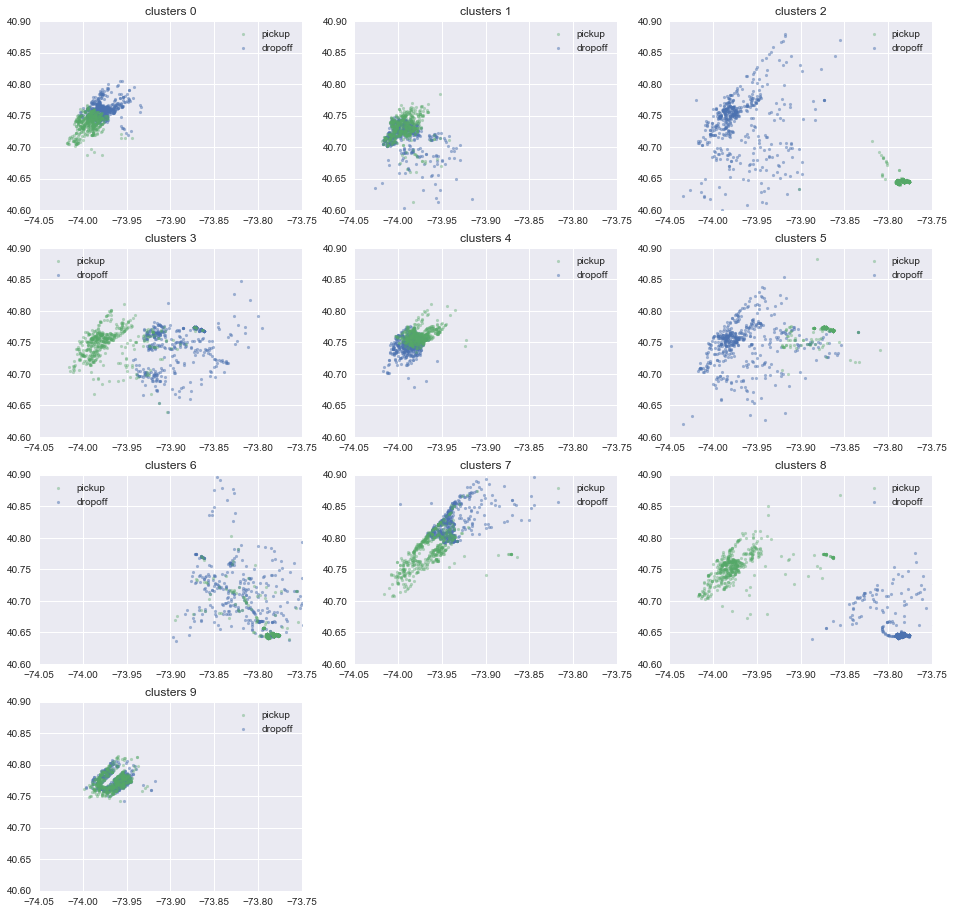

In [26]:
plt.figure(figsize=(16,16))
N = 500
for i in range(10):
    plt.subplot(4,3,i+1)
    tmp_data = data[data.pickup_dropoff_loc==i]
    drop = plt.scatter(tmp_data['dropoff_longitude'][:N], tmp_data['dropoff_latitude'][:N], s=10, lw=0, alpha=0.5,label='dropoff')
    pick = plt.scatter(tmp_data['pickup_longitude'][:N], tmp_data['pickup_latitude'][:N], s=10, lw=0, alpha=0.4,label='pickup')    
    plt.xlim([-74.05,-73.75]);plt.ylim([40.6,40.9])
    plt.legend(handles = [pick,drop])
    plt.title('clusters %d'%i)
#plt.axes().set_aspect('equal')

Some interesting facts:

 1. The short trips are clustered to the same clusters.
 2. Pickup location is more concentrated than dropoff one. This might just because the taxi driver doesn't want to reach out too far to pickup. Or there are more convenient way (like train) for people to go to the city.

## 1.4 Weather Features<a id='Weather Features'></a>
The weather data is obtained [here](https://www.kaggle.com/cabaki/knycmetars2016).

In [27]:
weather = pd.read_csv('../input/knycmetars2016/KNYC_Metars.csv', parse_dates=['Time'])
weather.head(3)

,Time,Temp.,Windchill,Heat Index,Humidity,Pressure,Dew Point,Visibility,Wind Dir,Wind Speed,Gust Speed,Precip,Events,Conditions
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast


In [28]:
print('The Events has values {}.'.format(str(set(weather.Events))))

The Events has values {'Fog', 'Fog\n\t,\nSnow', 'Rain', 'None', 'Fog\n\t,\nRain', 'Snow'}.


In [29]:
weather['snow']= 1*(weather.Events=='Snow') + 1*(weather.Events=='Fog\n\t,\nSnow')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour
weather = weather[weather['year'] == 2016][['month','day','hr','Temp.','Precip','snow','Visibility']]

In [30]:
weather.head()

,month,day,hr,Temp.,Precip,snow,Visibility
22,1,1,0,5.6,0.0,0,16.1
23,1,1,1,5.6,0.0,0,16.1
24,1,1,2,5.6,0.0,0,16.1
25,1,1,3,5.0,0.0,0,16.1
26,1,1,4,5.0,0.0,0,16.1


Merge the snow infomation to our data set.

In [31]:
data = pd.merge(data, weather, on = ['month', 'day', 'hr'], how = 'left')
test = pd.merge(test, weather, on = ['month', 'day', 'hr'], how = 'left')

In [32]:
weather_data = data[['Temp.','Precip','snow','Visibility']]
weather_test = test[['Temp.','Precip','snow','Visibility']]

Use the following code to save the features.
```
weather_data.to_csv('../features/weather_data.csv',index=False)
weather_test.to_csv('../features/weather_test.csv',index=False)```

In [33]:
weather_data.head()

,Temp.,Precip,snow,Visibility
0,4.4,0.3,0.0,8.0
1,28.9,0.0,0.0,16.1
2,-6.7,0.0,0.0,16.1
3,7.2,0.0,0.0,16.1
4,9.4,0.0,0.0,16.1


# 2. Outliers<a id='Outliers'></a>

As I said, we are using score as RMSLE, which cares less about outliers. **You should be able to completely skip this section without sacrifice your score**. Actually, if you specify too much outliers, like 500 of the data, you might run into problem: You will see the validation error is small but the submission score is bad. So proceed with caution here. Keep in mind in the competition we want to minimize the score of test set, which is randomly drawn from original set, so mistakes (if there is a lot) in your training set are much likely to be in your test set.

That being said, if the task is to predict the new data, I will remove more unresonable data points. Here I will just remove very tiny portion (7 of them) of our training set, which does not affect your model to a noticible decimal. **I create this section is just to show you how bizzard our real world data is, and how to identify and treat them properly**.

A better way to treat outliers (instead of deleting them right away) is to add a column with boolean value `True`(this sample is an outlier) or `False`.

In [34]:
outliers=np.array([False]*len(data))

First let's check the missing value. Let's hope there is not many of it.

In [35]:
print('There are %d rows that have missing values'%sum(data.isnull().any(axis=1)))

There are 56598 rows that have missing values


You can check the missing value using the above command on any dataframeyou have.

Note that the data from oscarleo (Subsection 1.2) has 1 missing values, since his data has 1 less row to the original data.

Unfortunately there is a lot of missing valuethe weather feature. However, as long as we stick to the plan of using gradient boost, we will be fine with this. Actually all the tree methods will be fine with this.

## 2.1 Outliers from 'trip_duration'<a id='Outliers from trip_duration'></a>

### `trip_duration` too big

Note that for column 'trip_duration', the unit is second. There are some samples that have ridiculus 100 days ride; that's the outliers. There are several tools to help you detect them: "run sequence plot", and "boxplot".

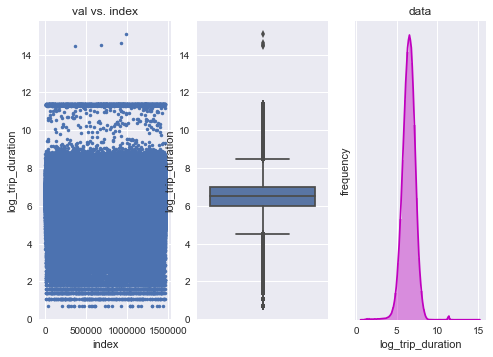

In [36]:
y = np.array(data.log_trip_duration)
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('log_trip_duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(y=data.log_trip_duration)
plt.subplot(133)
sns.distplot(y,bins=50, color="m");plt.yticks([]);plt.xlabel('log_trip_duration');plt.title('data');plt.ylabel('frequency')
#plt.hist(y,bins=50);

Looks like there are just 4 points that really far off. Also, there are a lot of `trip duration` in 
$$\exp(11.37)-1\approx86400,$$
which is 24 hrs. Well, I think it is still a possible thing, sometimes you take a taxi to a certain place then come back, and the clock just reset for every day, or simply they just forgot to turn off... That is the story I imagine. We can not treat them as outliers, despite how outliers they are, since it will happened in test set also. But for the 4 points, I think cast them to outliers is wise.

In [37]:
outliers[y>12]=True
print('There are %d entries that have trip duration too long'% sum(outliers))

There are 4 entries that have trip duration too long


There are several tests to decide the threshold of outliers. 

### `trip_duration` too small
I notice there are some rides only consists with 1 sec and have several miles on `total_distance`. I don't think teleportational taxi exist right now, thus it should be considered as outliers. I will calculate the km/hr using 

$$ \text{kph} = \frac{\text{total_distance}/1000}{\text{trip_duration}}\cdot3600 $$

Notice that several of the rides has 1 second `trip_duration` and nearly 0 `total_distance`. I think this might be a normal condition since the passenger can just walk off the taxi simply because he changes his mind.
 
Let's first make the run sequence plot to see how absurb those value is:

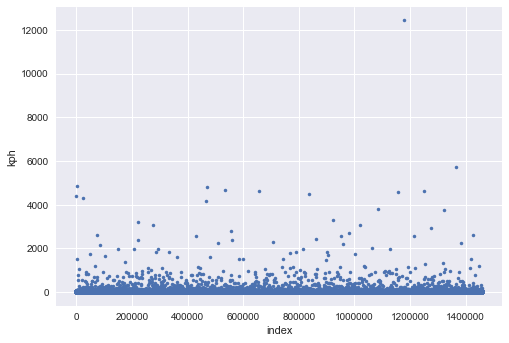

In [38]:
kph = osrm_data.total_distance/1000/data.trip_duration*3600
plt.plot(range(len(kph)),kph,'.');plt.ylabel('kph');plt.xlabel('index');plt.show()

As you can see, there are a lot of taxi drive beyond 1000 km/hr; there is a lot of recording error. If I am predict new values I will remove it. For this competition I simply keep all of them. If you still can't tolerant this error, you can use the following code to cast them to outliers.

```
kph = np.array(kph)
kph[np.isnan(kph)]=0.0
dist = np.array(osrm_data.total_distance) #note this is in meters
dist[np.isnan(dist)]=0.0
outliers_speeding = np.array([False]*len(kph))
outliers_speeding = outliers_speeding | ((kph>300) & (dist>1000))
outliers_speeding = outliers_speeding | ((kph>180)  & (dist<=1000))                                         
outliers_speeding = outliers_speeding | ((kph>100)  & (dist<=100))                                         
outliers_speeding = outliers_speeding | ((kph>80)  & (dist<=20))
print('There are %d speeding outliers'%sum(outliers_speeding))   
outliers = outliers|outliers_speeding```

## 2.2 Outliers from Locations<a id='Outliers from Locations'></a>
There are two locations, pickup and dropoff location. To find out if there is any outliers, I combine them and plot the boxplot.

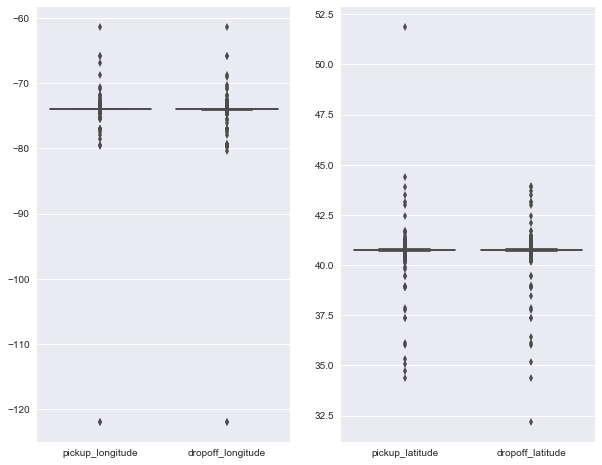

In [39]:
fig=plt.figure(figsize=(10, 8))
for i,loc in enumerate((['pickup_longitude','dropoff_longitude'],['pickup_latitude','dropoff_latitude'])):
    plt.subplot(1,2,i+1)
    sns.boxplot(data=data[outliers==False],order=loc);#plt.title(loc)

Both of the longtitudes has one points that is pretty far off the center(median). I will simply remove them.

In [40]:
outliers[data.pickup_longitude<-110]=True
outliers[data.dropoff_longitude<-110]=True
outliers[data.pickup_latitude>45]=True
print('There are total %d entries of ouliers'% sum(outliers))

There are total 7 entries of ouliers


As you can see the locations are pretty clump up, as the following plots indicates.

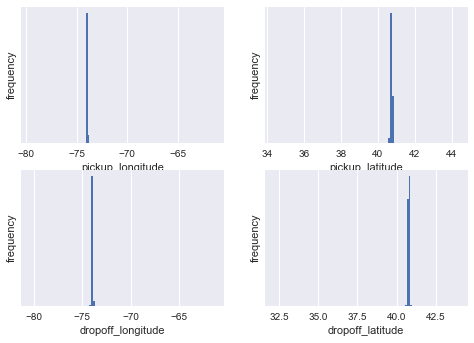

In [41]:
for i,feature in enumerate(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']):
    plt.subplot(2,2,i+1)
    data[outliers==False][feature].hist(bins=100)
    plt.xlabel(feature);plt.ylabel('frequency');plt.yticks([])
#plt.show();plt.close()

Let's plot some locations on the map with a very cool `folium` module, to get some ideas.

In [43]:
import folium # goelogical map
map_1 = folium.Map(location=[40.767937,-73.982155 ],tiles='OpenStreetMap',
 zoom_start=12)
#tile: 'OpenStreetMap','Stamen Terrain','Mapbox Bright','Mapbox Control room'
for each in data[:1000].iterrows():
    folium.CircleMarker([each[1]['pickup_latitude'],each[1]['pickup_longitude']],
                        radius=3,
                        color='red',
                        popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                        fill_color='#FD8A6C'
                        ).add_to(map_1)
map_1

In [44]:
print('I assign %d points as outliers'%sum(outliers))

I assign 7 points as outliers


In [45]:
Out = pd.DataFrame()
Out = Out.assign(outliers=outliers)

In [46]:
'''data = data.assign(outliers=outliers)
data.to_csv('../features/outliers.csv',index=False,columns=['outliers'])'''

"data = data.assign(outliers=outliers)\ndata.to_csv('../features/outliers.csv',index=False,columns=['outliers'])"

## 3. Analysis of Features<a id='Analysis of Features'></a>

### pickup_time vs trip_duration
Let's make box whisker plot on `pickup_time` vs `trip_duration`, it looks like there are our "rush hour" theory should be true here.

In [47]:
tmpdata = data
tmpdata = pd.concat([tmpdata,time_data],axis = 1)
tmpdata = tmpdata[outliers==False]

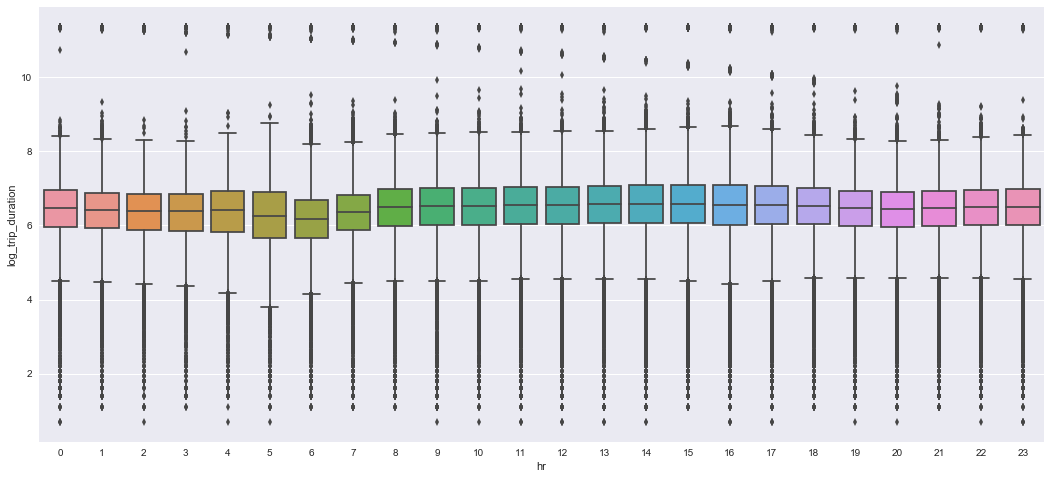

In [48]:
fig=plt.figure(figsize=(18, 8))
sns.boxplot(x="hr", y="log_trip_duration", data=tmpdata)

### month vs trip_duration
Let's do the same thing on `month` vs `trip_duration`. They look very very similar. Notice that `rest_day` is ploted in the figure. As you can see the trip is faster during rest_day.

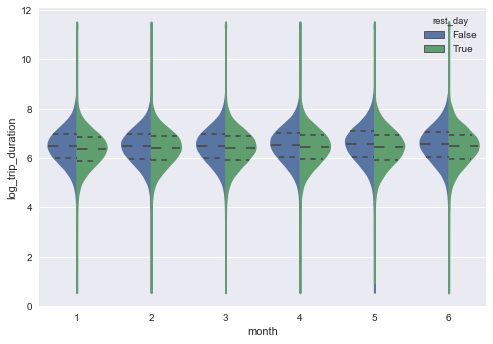

In [49]:
sns.violinplot(x="month", y="log_trip_duration", hue="rest_day", data=tmpdata, split=True,inner="quart")

### rest_day vs trip_duration
We suspect there should be difference on `rest_day` vs `trip_duration`. As we can see the following, when fix the time to be 7AM to 9AM, we see bigger difference between the rest day or not. Yes they have some difference, the median of `trip_duration` on work day is higher here.

In [50]:
tmpdata.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,right_steps,left_steps,pickup_dropoff_loc,Temp.,Precip,snow,Visibility,rest_day,weekend,pickup_time
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,1.0,1.0,9,4.4,0.3,0.0,8.0,False,False,17.400000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,2.0,2.0,1,28.9,0.0,0.0,16.1,True,True,0.716667
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,5.0,4.0,1,-6.7,0.0,0.0,16.1,False,False,11.583333


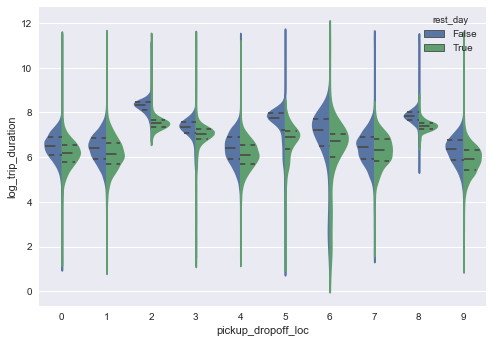

In [51]:
sns.violinplot(x="pickup_dropoff_loc", y="log_trip_duration",
               hue="rest_day", 
               data=tmpdata[np.array(tmpdata.pickup_time>7) & np.array(tmpdata.pickup_time<9)], 
               split=True,inner="quart")

Note that `pickup_dropoff_loc` (as described [here](#KmeansPlot) clustering both pickup and dropoff locations). The two clusters with highest `trip_duration` are clusters contains the trip on JFK airport. You can see that: in the rest day the trip is much faster than work day if you want to take taxi to or back from JFK.

## 4. XGB Model: the Prediction of `trip_duration`<a id='XGB Model'></a>

Here we have done all the preparation. Let's put this into `xgboost` model and get our feet wet!

In [178]:
mydf = data[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag']]

testdf = test[['vendor_id','passenger_count','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude','store_and_fwd_flag']]

In [179]:
print('There are %d samples in the test data'%len(testdf))

There are 625134 samples in the test data


#Use these code if you have your features saved in .csv file.
```
outliers = pd.read_csv('../features/outliers.csv')
time_data       = pd.read_csv('../features/time_data.csv')
weather_data    = pd.read_csv('../features/weather_data.csv')
osrm_data       = pd.read_csv('../features/osrm_data.csv')
Other_dist_data = pd.read_csv('../features/Other_dist_data.csv')
kmean10_data    = pd.read_csv('../features/kmean10_data.csv')

time_test       = pd.read_csv('../features/time_test.csv')
weather_test    = pd.read_csv('../features/weather_test.csv')
osrm_test       = pd.read_csv('../features/osrm_test.csv')
Other_dist_test = pd.read_csv('../features/Other_dist_test.csv')
kmean10_test    = pd.read_csv('../features/kmean10_test.csv')```

 `kmean10_data` and `kmean10_test` is categorical, we need to transform it to one-hot representation for `xgboost` module to treat it correctly.

In [180]:
kmean_data= pd.get_dummies(kmean10_data.pickup_dropoff_loc,prefix='loc', prefix_sep='_')    
kmean_test= pd.get_dummies(kmean10_test.pickup_dropoff_loc,prefix='loc', prefix_sep='_')    

In [181]:
mydf  = pd.concat([mydf  ,time_data,weather_data,osrm_data,Other_dist_data,kmean_data],axis=1)
testdf= pd.concat([testdf,time_test,weather_test,osrm_test,Other_dist_test,kmean_test],axis=1)

In [182]:
if np.all(mydf.keys()==testdf.keys()):
    print('Good! The keys of training feature is identical to those of test feature')
else:
    print('Oops, something is wrong, keys in training and testing are not matching')    

Good! The keys of training feature is identical to those of test feature


Note that the evaluation is $$\sqrt{\frac {1}{n}\sum_{i=1}^n (\log(y_i+1)-\log(\hat{y}_i+1))^2},$$ which make sense because the response `y=trip_dutation` is a positive number and it should be transformed to real values.

I will specifying $$z_i = \log(y_i+1).$$ The corresponding squared loss function is 
$$\sqrt{\frac{1}{n}\sum_{i=1}^n (z_i-\hat{z}_i)^2},$$
i.e. the usual rmse.

I use `X` to represent my features and `z` to represent the responding `log_trip_duration`.

In [183]:
X = mydf[Out.outliers==False]
z = data[Out.outliers==False].log_trip_duration.values

In [184]:
if np.all(X.keys()==testdf.keys()):
    print('Good! The keys of training feature is identical to those of test feature.')
    print('They both have %d features, as follows:'%len(X.keys()))
    print(list(X.keys()))
else:
    print('Oops, something is wrong, keys in training and testing are not matching')

Good! The keys of training feature is identical to those of test feature.
They both have 32 features, as follows:
['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'rest_day', 'weekend', 'pickup_time', 'Temp.', 'Precip', 'snow', 'Visibility', 'total_distance', 'total_travel_time', 'number_of_steps', 'right_steps', 'left_steps', 'haversind_dist', 'manhattan_dist', 'bearing', 'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5', 'loc_6', 'loc_7', 'loc_8', 'loc_9']


### 4.1 Using XGBoost Module<a id='Using XGBoost Module'></a>
The complete document about the paramters in xgboost can be found [here](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

Basically, it is the 'accelerated' **Gradient Boost Machine (GBM)**. Briefly speaking, for square loss (used in regression), GBM on data $$(x_{i},y_{i})_{i=1}^{n}$$ is

1. Initialize F(x)=mean(y).

2. For i in 1,2,...,n, let the residual be $$r_{i}= y_{i}-F(x_{i}).$$

3. Using (features,residual) as (independent variable,response variable), i.e. $$(x_{i},r_{i})_{i=1}^{n},$$ to build a regression tree, f, till a certain depth.

4. Update F(x) as F(x) + f(x).

5. Repeat step 2-4 again

Note that in step 3, we use a decision tree so there is no need to rescale feature values. And no need to worry about multicollinearity (this is because, by default, the tree will partition the feature space, and fit a constant value, the mean of y in the partition, as a prediction).

To prevent overfitting, the regularization can be done with the following three aspects:

 1. In step 3, a boostrap sample can be drawn for building a tree. This is controlled by `subsample` rate (0~1).
 2. In step 2, one can update the residual $r_i$ as $$y_{i}-\eta F(x_{i}),$$ where $\eta$ is the **learning rate** (parameter `eta`).
 3. In step 3, when building a tree, one can put L1 or L2 regularization term to prevent overfitting. Also, one can control the complexity of the tree by setting `max_depth` and `min_child_weight` (the number of samples in the smallest leave).

One needs to pay extra attention to categorical features. In theory, tree algorithm can handle categorical features, but module like `sklearn` or `xgboost` here will treat it as numerical. So, if there is a categorical features you will need to tranform it to one-hot features. However, if there are too many categorical levels for a feature, it will result in a very sparse matrix for your one-hot features, which make a tree algorithm hard to choose from it.

In [185]:
import xgboost as xgb

Note that I only use the data's first 50000 samples, just to keep the kernel running. 

In [186]:
X = X[:50000]
z = z[:50000]

In [187]:
from sklearn.model_selection import train_test_split

#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=0)
Xcv,Xv,Zcv,Zv = train_test_split(Xval, Zval, test_size=0.5, random_state=1)
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xcv   , label=Zcv)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [188]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:linear',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10,
         'nthread'  :3}  #number of cpu core to use

model = xgb.train(parms, data_tr, num_boost_round=1000, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=100)

print('score = %1.5f, n_boost_round =%d.'%(model.best_score,model.best_iteration))

[0]	train-rmse:4.22534	valid-rmse:4.2289
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
Stopping. Best iteration:
[32]	train-rmse:0.328163	valid-rmse:0.455909

score = 0.45591, n_boost_round =32.


For people who want to get better score, here is my suggestion:

1. Using lower `eta`
2. Using lower `min_child_weight`
3. Using larger `max_depth`

And run cross validation to find the best combination of parameters. (My final score took about 2 hr to run.)

### 4.2 The Submission<a id='The Submission'></a>


In [189]:
data_test = xgb.DMatrix(testdf)
ztest = model.predict(data_test)

Convert z back to y:$$y = e^z-1$$

In [190]:
ytest = np.exp(ztest)-1
print(ytest[:10])

[  848.11004639   369.03869629   405.24002075   938.07592773   280.09396362
   889.91900635  1902.23449707   887.81054688  2616.98095703   407.53829956]


Creat the submission file.

In [192]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': ytest})
# submission.to_csv('submission.csv', index=False)

### 4.3 Importance for each Feature<a id='Importance for each Feature'></a>

A great thing about GBM, as well as all the tree based agorithms, is that we can examine the importance of each feature. Usually the importance can be calculated by 

1. The number of feature that being select to build a tree.
2. The gain (in terms of loss function) of using the feature to build a tree.

The default is using the first definition of the importance.

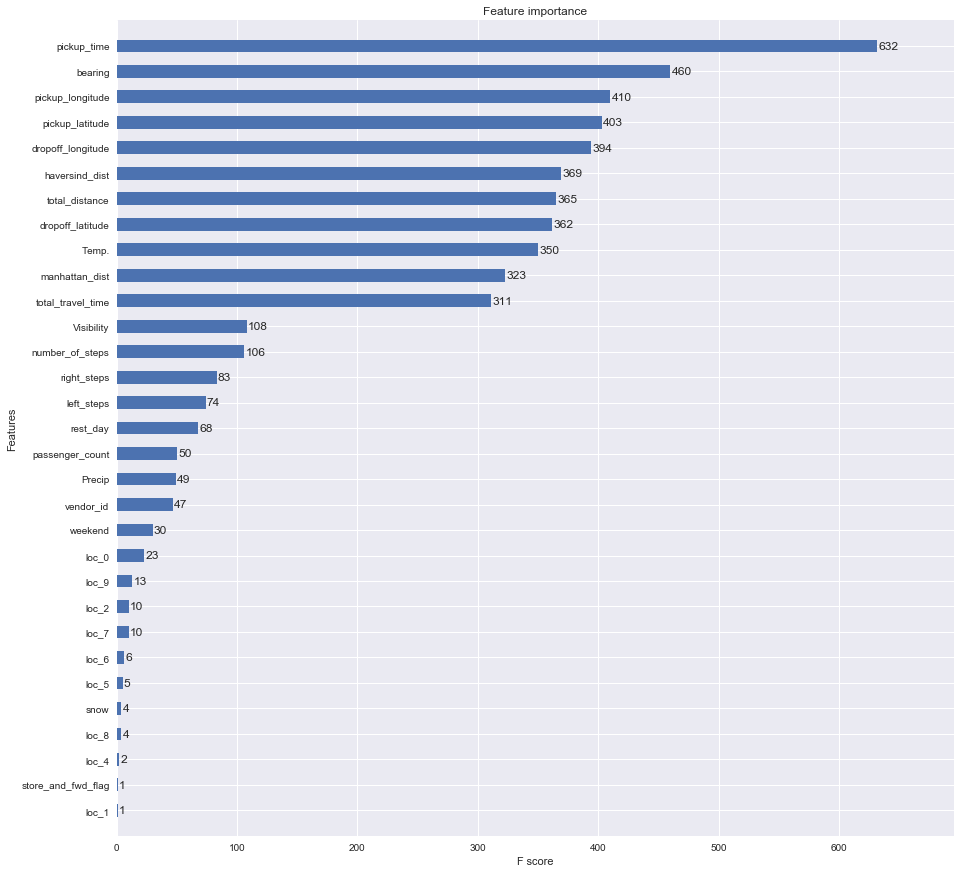

In [193]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(model,ax = axes,height =0.5)
plt.show();plt.close()

It seems `pickup_time` is the most important features, rush hour will serious affect the trip duration. Several distance feature like `haversind_dist`, `total_distance` (from OSRM), and `mahatten_dist`, doing very well, too. `total_travel_time` from OSRM data has high impact, also.

Some other thoughts about the result: 

1. `Temp.`: I am suprise to see temperature gets importance here. My theory is that when it is too cold or too hot, people don't want to walk outside.
2. K-means location doesn't receive many importance here, maybe I separte them too much. I'll try less clusters and see how it does.
3. I suspect the workday and rest day should matter, however, it is not showing much in the importance plot. Perhap `rest_day` and `weekend` are two too similar features so the result is diluted.

Some thoughts about additional features:
From OSRM data we see all the information about the fastest route, so if anyone can acquire the population, or car registration number, of each town it passed by, weighted by the distance it travel throug the town, and aggregate them, it should be a good additional features.

Thank you for your reading, let me know what you think!

Best,

Weiying Wang
